In [1]:
import warnings
warnings.filterwarnings('ignore')

from astropy.table import Table, join, vstack
import astropy.units as au
import numpy as np
from glob import glob
import os

In [2]:
# Define names and filenames...

galaxy = 'ngc0628'
galaxy_hst = 'ngc628e'
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/'

dendro_dir = '%s/data_hstha_nebulae_catalogue/' %(root_dir)
sample_table_file = '%s/data_misc/sample_table/phangs_sample_table_v1p6.fits' %root_dir
muscat_table_file = '%s/data_misc/nebulae_catalogue/Nebulae_catalogue_v3.fits' %root_dir

print(dendro_dir)
print(sample_table_file)
print(muscat_table_file)

/Users/abarnes/Dropbox/work/Smallprojects/galaxies//data_hstha_nebulae_catalogue/
/Users/abarnes/Dropbox/work/Smallprojects/galaxies//data_misc/sample_table/phangs_sample_table_v1p6.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies//data_misc/nebulae_catalogue/Nebulae_catalogue_v3.fits


In [3]:
tables = []
for root, dirs, files in os.walk(dendro_dir):
    for file in files:
        if file.endswith("props_all.fits"):
             print(os.path.join(root, file))
             tables += [Table.read(os.path.join(root, file))]

/Users/abarnes/Dropbox/work/Smallprojects/galaxies//data_hstha_nebulae_catalogue/ngc3627/dendro/props_all.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies//data_hstha_nebulae_catalogue/ngc4254/dendro/props_all.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies//data_hstha_nebulae_catalogue/ngc1433/dendro/props_all.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies//data_hstha_nebulae_catalogue/ngc5068/dendro/props_all.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies//data_hstha_nebulae_catalogue/ngc4321/dendro/props_all.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies//data_hstha_nebulae_catalogue/ngc1365n/dendro/props_all.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies//data_hstha_nebulae_catalogue/ngc4303/dendro/props_all.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies//data_hstha_nebulae_catalogue/ngc1087/dendro/props_all.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies//data_hstha_nebulae_catalogue/ngc7496/dendro/props_all.fits


In [5]:
# Join tables
table = vstack(tables)

# Order by galaxy names and region IDs from MUSE
gal_name = table['gal_name']
table.remove_column('gal_name')
table.add_column(gal_name, index=0)
table.sort(['gal_name', 'region_ID'])

# Remove masked values

mask = table['_idx'].mask
table_masked = table[~mask]

In [6]:
table_masked['HA6562_LUMINOSITY_HST'][table_masked['HA6562_FLUX_HST_CORR'].mask] = np.nan

In [7]:
table_masked.write(dendro_dir+'/all/nebulae_catalogue.fits', overwrite=True)

In [8]:
table_masked

gal_name,region_ID,hstcat_region_ID,_idx,area_ellipse,area_exact,HA6562_FLUX_HST,major_sigma,minor_sigma,position_angle,mean_sigma,x_cen,y_cen,radius_trunk,radius_trunkclose,major_fwtm,minor_fwtm,mean_fwtm,mean_hwtm,major_fwhm,minor_fwhm,mean_fwhm,mean_hwhm,min_npix,min_value_sig,min_delta_sig,radius_trunk_pc,radius_trunkclose_pc,major_fwtm_pc,minor_fwtm_pc,mean_fwtm_pc,mean_hwtm_pc,major_fwhm_pc,minor_fwhm_pc,mean_fwhm_pc,mean_hwhm_pc,ra_cen,dec_cen,mean_sigma_pc,x_max,y_max,ra_max,dec_max,flag_edge_hst,cen_x,cen_y,cen_ra,cen_dec,cen_x_geo,cen_y_geo,flag_edge,flag_nearby,flag_star,deproj_dist,deproj_phi,region_area,region_circ_rad,HB4861_FLUX,OIII5006_FLUX,HA6562_FLUX,NII6583_FLUX,SII6716_FLUX,SII6730_FLUX,SIII9068_FLUX,OI6300_FLUX,NII5754_FLUX,HEI5875_FLUX,SIII6312_FLUX,OI6363_FLUX,OII7319_FLUX,OII7330_FLUX,HB4861_FLUX_ERR,OIII5006_FLUX_ERR,HA6562_FLUX_ERR,NII6583_FLUX_ERR,SII6716_FLUX_ERR,SII6730_FLUX_ERR,SIII9068_FLUX_ERR,OI6300_FLUX_ERR,NII5754_FLUX_ERR,HEI5875_FLUX_ERR,SIII6312_FLUX_ERR,OI6363_FLUX_ERR,OII7319_FLUX_ERR,OII7330_FLUX_ERR,HA6562_SIGMA,NII6583_SIGMA,OIII5006_SIGMA,HA6562_VEL,NII6583_VEL,OIII5006_VEL,HA6562_SIGMA_ERR,NII6583_SIGMA_ERR,OIII5006_SIGMA_ERR,HA6562_VEL_ERR,NII6583_VEL_ERR,OIII5006_VEL_ERR,HB4861_FLUX_CORR,OIII5006_FLUX_CORR,HA6562_FLUX_CORR,NII6583_FLUX_CORR,SII6716_FLUX_CORR,SII6730_FLUX_CORR,SIII9068_FLUX_CORR,OI6300_FLUX_CORR,NII5754_FLUX_CORR,HEI5875_FLUX_CORR,SIII6312_FLUX_CORR,OI6363_FLUX_CORR,OII7319_FLUX_CORR,OII7330_FLUX_CORR,HB4861_FLUX_CORR_ERR,OIII5006_FLUX_CORR_ERR,HA6562_FLUX_CORR_ERR,NII6583_FLUX_CORR_ERR,SII6716_FLUX_CORR_ERR,SII6730_FLUX_CORR_ERR,SIII9068_FLUX_CORR_ERR,OI6300_FLUX_CORR_ERR,NII5754_FLUX_CORR_ERR,HEI5875_FLUX_CORR_ERR,SIII6312_FLUX_CORR_ERR,OI6363_FLUX_CORR_ERR,OII7319_FLUX_CORR_ERR,OII7330_FLUX_CORR_ERR,EBV,EBV_ERR,met_scal,met_scal_err,logq_D91,logq_D91_err,t_N2,t_S3,t_N2_err,t_S3_err,BPT_NII,BPT_SII,BPT_OI,LOG_SIGMA_SFR_CHAB,LOG_SIGMA_STMASS_CHAB,5thNN_dist,NN_number,Environment,r_R25,r_reff,Lum_HA6562_CORR,Delta_met_scal,pc_per_pixel,EW_HA6562_raw,EW_HA6562_raw_ERR,EW_HB4861_raw,EW_HB4861_raw_ERR,EW_HA6562_fit,EW_HA6562_fit_ERR,EW_HB4861_fit,EW_HB4861_fit_ERR,EW_HA6562_bgcorr,EW_HA6562_bgcorr_ERR,EW_HB4861_bgcorr,EW_HB4861_bgcorr_ERR,HII_class_v2,HII_class_v3,HA6562_FLUX_HST_CORR,HA6562_LUMINOSITY_HST,region_circ_rad_pc,flag_nearby_hst
,,,,arcsec2,arcsec2,erg / (s cm2),arcsec,arcsec,deg,arcsec,pix,pix,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,,,,pc,pc,pc,pc,pc,pc,pc,pc,pc,pc,deg,deg,pc,pix,pix,deg,deg,,pix,pix,deg,deg,pix,pix,,,,arcsec,rad,pix2,arcsec,1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),mag,mag,,,,,K,K,K,K,,,,solMass / (yr kpc2),solMass / kpc2,pc,,,,,erg / s,,pc,,,,,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,,,erg / (s cm2),erg / s,pc,
bytes32,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,i

In [9]:
table_barnes21 = Table.read('/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/catalouge/v2/physprops/master.fits') 
table_all = join(table_masked, table_barnes21, keys=['region_ID', 'gal_name'])

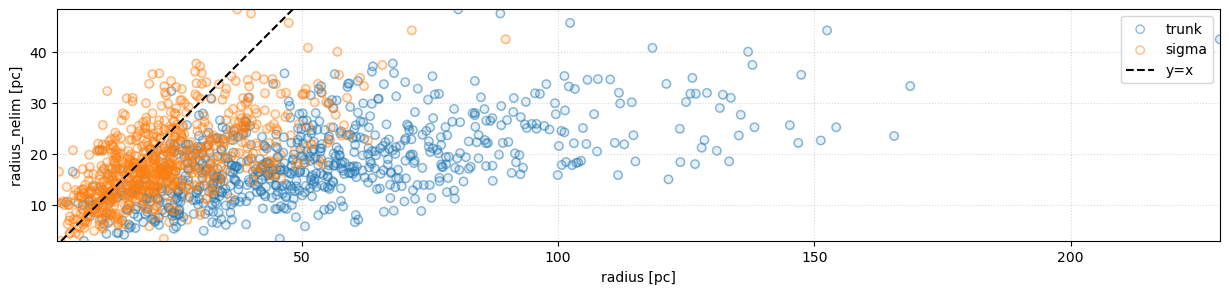

In [19]:
radius_nelim = table_all['reff_Halphalowerlim']
radius_sigma = table_all['mean_sigma_pc']
radius = table_all['radius_trunkclose_pc']
mask_ne = (table_all['ne_sig'] & (table_all['flag_touch_hst']!=1))

radius_nelim = radius_nelim[mask_ne]
radius_sigma = radius_sigma[mask_ne]
radius = radius[mask_ne]

fig, axs = plt.subplots(1, 1, figsize=(15, 15))
axs.set_aspect('equal')

axs.scatter(radius, radius_nelim, fc='C0', ec='C0', alpha=0.1)
axs.scatter(radius, radius_nelim, fc='none', ec='C0', alpha=0.5, label='trunk')

axs.scatter(radius_sigma, radius_nelim, fc='C1', ec='C1', alpha=0.1)
axs.scatter(radius_sigma, radius_nelim, fc='none', ec='C1', alpha=0.5, label='sigma')

axs.plot([0, 1e3], [0, 1e3], c='k', ls='--', label='y=x')

axs.set_xlim(np.nanmin([radius_sigma, radius]), np.nanmax([radius_sigma, radius]))
axs.set_ylim(np.nanmin(radius_nelim), np.nanmax(radius_nelim))

axs.set_xlabel('radius [%s]' %radius.unit)
axs.set_ylabel('radius_nelim [%s]' %radius_nelim.unit)
axs.grid(True, ls=':', alpha=0.5)
axs.legend()